# Mantisshrimp begginer's tutorial

In this tutorial we'll go through to how to finetune a model in the [wheat](https://www.kaggle.com/c/global-wheat-detection/overview/eccv-2020) dataset, where we are tasked to find the bounding boxes locations of wheat heads in the image.

There is also a [Kaggle notebook]() version of this tutorial, where the dataset is already downloaded and the libraries easily installed.

### Step 0: Imports

Mantisshrimp is designed with developer productivity as it first goal, and that already starts at the imports level. The recommended way of importing the library is `from mantisshrimp.all import *`, this will import a curated list of packages (like numpy and torch) and all the necessary modules

In [1]:
#hide
from mantisshrimp.all import *
import pandas as pd, albumentations as A

/home/lgvaz/anaconda3/envs/light2/lib/python3.7/site-packages/graphql/type/directives.py:55: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  assert isinstance(locations, collections.Iterable), 'Must provide locations for directive.'
/home/lgvaz/anaconda3/envs/light2/lib/python3.7/site-packages/graphql/type/typemap.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import OrderedDict, Sequence, defaultdict
/home/lgvaz/anaconda3/envs/light2/lib/python3.7/site-packages/trains/backend_interface/metrics/events.py:27: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.attrs(cmp=False, slots=True)


### Step 1: Data parsers

Often the step of getting our data into a standard format is the most difficult one. Almost all datasets comes in their unique own format, and writing custom code to handle each one of them can be very time consuming

Mantisshrimp provides an easy `Parser` interface for handling that, the main idea is that you only have to define how to parse a single sample and the library takes care of the rest

But before all, let's get the path to our dataset and read the CSV file using `pandas`

In [2]:
source = Path('/home/lgvaz/.data/wheat')
df = pd.read_csv(source/'train.csv')

There are two types of parsers we have to define:
* `InfoParser`: Parses metadata information about our images, like the image `id`, `file_path`, `height` and `width`
* `AnnotationParser`: Parses our annotations, like bounding boxes, masks and keypoints

In [3]:
class WheatInfoParser(InfoParser):
    def filepath(self, o): return self.source/f'train/{o.image_id}.jpg'
    def imageid(self, o): return o.image_id
    def h(self, o): return o.height
    def w(self, o): return o.width
    def __iter__(self): yield from self.data.itertuples()

In [4]:
class WheatAnnotationParser(AnnotationParser):
    def imageid(self, o): return o.image_id
    def label(self, o): return 0
    def bbox(self, o): return BBox.from_xywh(*np.fromstring(o.bbox[1:-1], sep=','))
    def __iter__(self): yield from df.itertuples()

Define a `CategoryMap`, each `Category` receives an object id and it's name

In [5]:
catmap = CategoryMap([Category(0, 'wheat')])

In [6]:
parser = DataParser(df, source, catmap=catmap,
                    info_parser=WheatInfoParser,
                    annotation_parser=WheatAnnotationParser)

The `.parse` method will run the parser over all data points, grouping all images that share the same `id`  
By default it returns two lists of `Records` with a 0.8/0.2 `train/validation` split

In [7]:
train_rs,valid_rs = parser.parse()


Removed 0 images that don't have annotations


### Step 2: Transforms, Datasets, and DataLoaders

Mantisshrimp does not implement transforms on it's own, but it instead relies on an easy interface for integrating any transforms library. It currently supports [albumentations](https://github.com/albumentations-team/albumentations) out of the box

In [8]:
tfm = AlbuTransform([A.Flip(p=.8), A.ShiftScaleRotate(p=.8, scale_limit=(0, .5))])

Since we only defined augmentation transforms, we only want to apply them to the training dataset

In [9]:
train_ds = Dataset(train_rs, tfm)
valid_ds = Dataset(valid_rs)

We use `RCNNDataLoader` for creating our data loaders, it receives the same arguments as a standard pytorch `DataLoader`

In [10]:
train_dl = RCNNDataLoader(train_ds, batch_size=4, num_workers=8)
valid_dl = RCNNDataLoader(valid_ds, batch_size=4, num_workers=8)

**Bonus:** Let's take a look at how our transforms are affecting the same training sample:

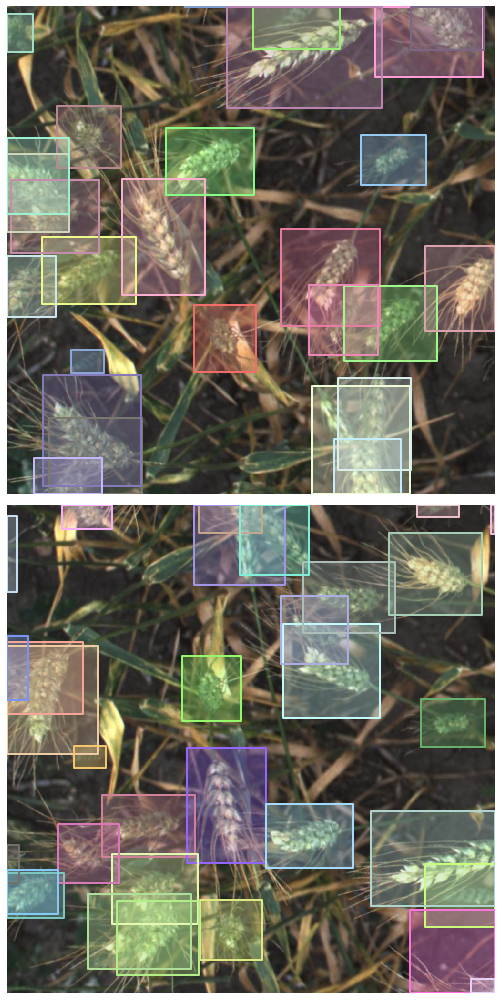

In [11]:
items = [train_ds[0] for _ in range(2)]
grid2([partial(show_item, o, label=False) for o in items])

### Step 3 (optional): Metrics

Let's use the same evaluation metric that COCO uses

In [12]:
metrics = [COCOMetric(valid_rs, catmap)]


creating index...
index created!


### Step 3: Model and Training

Mantisshrimp provides a high and a mid level interface for training. One is not better than the other, they instead serve different purposes:
* High level interface: For quick prototyping in a jupyter notebook like environment
* Mid level interface: For more reproducible experiments. Great for writing experiments that can be launched in terminal with different hyperparameters

#### High level interface (Learner)

The `Learner` interface is inspired (and very similar) to the [fastai](https://github.com/fastai/fastai2) `Learner`. It aims to provide a very productive experience for prototyping in a jupyter notebook like environment  
It comes bundled with additional functionallity, like inbuilt learning rate schedulers and differential learning rates for training unfreezed models

Since our problem only contain bounding boxes, we're going to use the `FasterRCNN` model

In [13]:
model = MantisFasterRCNN(len(catmap), metrics=metrics)

The `Learner` receives an argument called `opt_fn`, it will call this function passing the model parameters and it expects to receive back a torch `Optimizer`. We are going to use `partial` to pass any additional paramters to our `SGD` optimizer

In [14]:
opt_fn = partial(SGD, momentum=.9, weight_decay=5e-4)

In [15]:
learn = Learner(model, train_dl, valid_dl, opt_fn)

`fit_one_cycle` will train adjusting the learning rate acording with the [1cycle learning rate policy](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.OneCycleLR)

In [16]:
learn.fit_one_cycle(5, 1e-3)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

    | Name                                  | Type                     | Params
-------------------------------------------------------------------------------
0   | m                                     | FasterRCNN               | 41 M  
1   | m.transform                           | GeneralizedRCNNTransform | 0     
2   | m.backbone                            | BackboneWithFPN          | 26 M  
3   | m.backbone.body                       | IntermediateLayerGetter  | 23 M  
4   | m.backbone.body.conv1                 | Conv2d                   | 9 K   
5   | m.backbone.body.bn1                   | FrozenBatchNorm2d        | 0     
6   | m.backbone.body.relu                  | ReLU                     | 0     
7   | m.backbone.body.maxpool               | MaxPool2d                | 0     
8   | m.backbone.body.layer1                | Sequential               | 212 K 
9   

/home/lgvaz/anaconda3/envs/light2/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Accumulating evaluation results...
DONE (t=0.94s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

/home/lgvaz/git/pytorch-lightning/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


Accumulating evaluation results...
DONE (t=0.85s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.053
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.204
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.190
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Accumulating evaluation results...
DONE (t=0.84s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.078
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Accumulating evaluation results...
DONE (t=0.87s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.595
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

Accumulating evaluation results...
DONE (t=0.89s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

#### Mid level interface (Lightning Trainer)

This is almost pure Lightning, go crazy!  
For simplicity, let's just define a model that uses `SGD` and the 1cycle policy like before

In [24]:
class WheatModel(MantisFasterRCNN):
    def configure_optimizers(self):
        opt = SGD(params(self), lr=1e-3, momentum=.9, weight_decay=5e-4)
        sched = OneCycleLR(opt, max_lr=1e-3, total_steps=len(train_dl), pct_start=.3)
        return [opt], [{'scheduler':sched, 'interval':'step'}]

In [25]:
model = WheatModel(len(catmap), metrics=metrics)

In [27]:
trainer = Trainer(max_epochs=1, gpus=1)
trainer.fit(model, train_dl, valid_dl)

### Extra: Visualize results

Because we are using Lightning logs are automatically saved for us in a tensorboard format. Other cool loggers like [wandb](https://www.wandb.com/) are also provided by lightning!

Let's take a look at some model predictions (`learn.show_results` if using `Learner`)

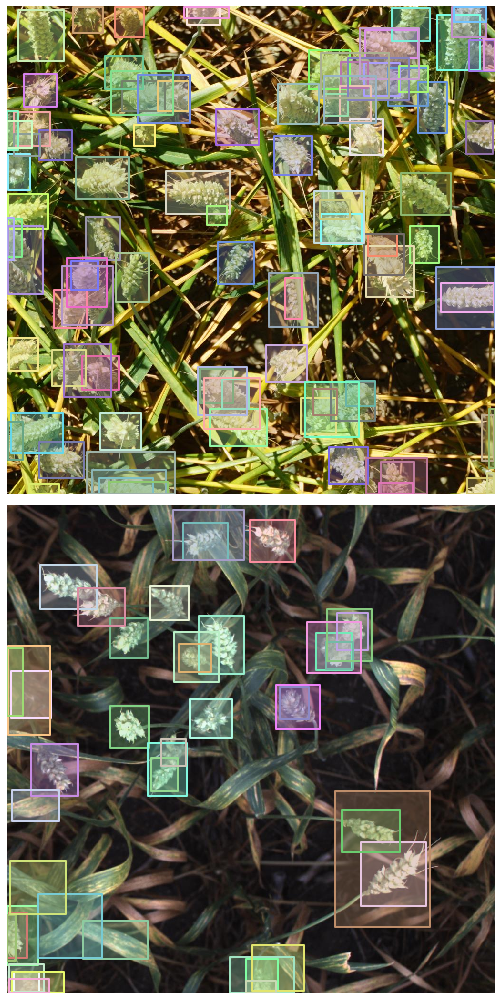

In [24]:
rs = random.choices(valid_rs, k=2)
ims,preds = model.predict(rs=rs)
show_preds(ims, preds)